In [1]:
import galprime as gp

import numpy as np

from matplotlib import pyplot as plt

from scipy.signal import convolve2d
from scipy.stats import norm

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

In [2]:
config = gp.default_config()

In [3]:
backgrounds = gp.Cutouts.from_file("../pdata/cutouts_i.fits")
psfs = gp.Cutouts.from_file("../pdata/i_psfs.fits")

<ipython-input-4-82c20b68b933>:10: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(combined))


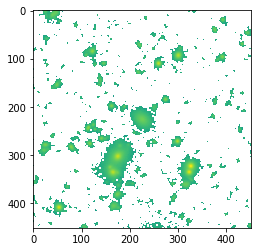

In [4]:

example_bg = backgrounds.cutouts[5]
example_psf = psfs.cutouts[5]

mod = gp.SingleSersicModel()

mod_z = mod.generate(params={"MAG":22, "REFF":12, "SHAPE":example_bg.shape})[0]
mod_convolved = convolve2d(mod_z, example_psf, mode="same")

combined = mod_convolved + example_bg + 0.01
plt.imshow(np.log10(combined))


In [5]:
data_mask = gp.gen_mask(combined, config)
profile = gp.isophote_fitting(np.ma.masked_array(combined, mask=data_mask[0]), config)["ISOLIST"]



(0.009045937561644417, 0.008874912556279464, 0.02155833735756003)


0.5706233412220004

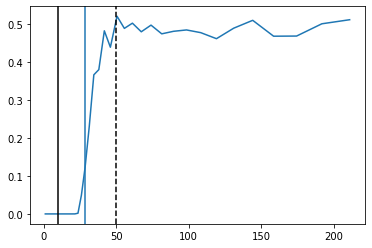

In [ ]:


bg_stats = gp.estimate_background_sigclip(combined, config)
print(bg_stats)


def profile_quality(profile, bg_info, r50_mult=5, alpha=0.05):
    """
    Evaluate the quality of a given profile based on background information and specified parameters.
    Parameters:
        profile (dict): The extracted profile in table or isolist format.
        bg_info (tuple): A tuple containing background information (mean, standard deviation).
        r50_mult (float, optional): A multiplier for the r50 value to determine the threshold. Default is 5.
            This is how far we would ideally like to extract the profile to, all things considered.
        alpha (float, optional): Significance level for the threshold calculation. Default is 0.05.
            1 - alpha is the percentage confidence that a given value does not belong to the background.
    Returns:
        float: A quality metric between 0 and 1, indicating the quality of the profile.
    """

    profile = gp.ensure_profile_format(profile)
    sma, intens = profile['sma'], profile['intens']
    
    r50_idx, r50_val = gp.r50(profile['sma'], profile['intens'])

    sf = 1 - norm.cdf(intens, loc=bg_info[1], scale=bg_info[2])
    
    threshold_index = np.argmin(sf < alpha)
    threshold = sma[threshold_index]
    
    plt.plot(sma, sf)
    plt.axvline(threshold)
    plt.axvline(r50_val, color="black")
    plt.axvline(r50_val * r50_mult, color="black", linestyle="--")

    try:
        quality = np.clip(threshold / (r50_val * r50_mult), 0, 1)
    except ZeroDivisionError:
        quality = 0
    
    return quality
    


profile_quality(profile, bg_stats)